In [580]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans  
from sklearn import metrics
from sklearn.metrics import classification_report

import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/mnt/nfs/jupyter-sources/vn/utils.py'>

# Data Preprocessing

In [581]:
dataset = pd.read_csv('loads_dataset.csv.gz',compression = 'gzip')
time_cols = ['event_timestamp','cycle_start','cycle_end','step_start_time','step_end_time']
dataset[time_cols] = dataset[time_cols].apply(lambda col: pd.to_datetime(col))
dataset = dataset.fillna(0)

## Analyzing the crane movement

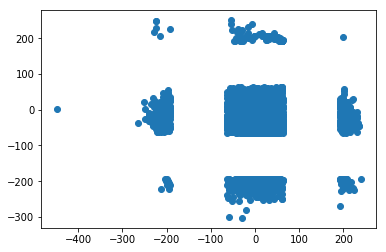

In [582]:
plt.scatter(dataset['acc_ax'],dataset['acc_ay'])
plt.show()

We can see that there are 9 clear areas of movements. I will classify the points into 9 different classes and add those area as a new feature

In [583]:
kmeans = KMeans(n_clusters=9)  
kmeans.fit(dataset[['acc_ax','acc_ay']].values)  
dataset['area'] = kmeans.labels_

# Create Features

In [584]:
truthset = pd.concat([utils.steps_time_calc(dataset),utils.cycle_time_calc(dataset),utils.weighted_avg_step_weight_calc(dataset),
                      utils.median_step_weight_calc(dataset),utils.load_rigging_area(dataset)],axis=1)

# Matching Labels

In [585]:
truthset, loads_mapping = utils.match_labels(dataset, truthset)

number of cycles per category: load_type_name
Concrete                 36
Formwork accessories      6
Formworks               725
Mesh                    305
Wood                     30
dtype: int64


# Over Sampling
The dataset is unbalanced. The maing load types are Formworks and Mesh. I will oversample the dataset and remove the Formwork accessories since there are not enough samples to train the model on

In [586]:
truthset = truthset[truthset['load_type_label'] != 1]

In [587]:
X = truthset.loc[:, truthset.columns != 'load_type_label']
y = truthset.loc[:, truthset.columns == 'load_type_label']
# oversampling using smote to create balanced database
os = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

/home/prod/vm/jupyter/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Training a Logistic Regression Model

In [588]:
X_train, X_validation, y_train, y_validation = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/prod/vm/jupyter/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/prod/vm/jupyter/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Testing the Model

In [589]:
y_pred = logreg.predict(X_validation)
print(classification_report(y_validation, y_pred), loads_mapping)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       154
           2       0.68      0.49      0.57       147
           3       0.68      0.65      0.66       169
           4       0.77      0.93      0.84       147

   micro avg       0.76      0.76      0.76       617
   macro avg       0.75      0.76      0.75       617
weighted avg       0.75      0.76      0.75       617
 {0: 'Concrete', 1: 'Formwork accessories', 2: 'Formworks', 3: 'Mesh', 4: 'Wood'}
